# Collector

In [1]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

# import sklearn
# import scipy

# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lightgbm
# from xgboost import XGBClassifier
# import keras

# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek 

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [2]:
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

In [3]:
# Зададим path для папки проекта и для папок файлов
path_project_folder = 'C:/DAN/t_systems/trade_project/'
folder_name_headlines = 'backup_headlines/'
folder_name_logger = 'logger/'

In [32]:
# Для работы с API нужен запущенный терминал Thomson Reuters Eikon
# Зададим API ключ - не даёт доступ сам по себе
ek.set_app_key('ccebd1ff788d4574818be93e35c4741925ac214e') # df6c94f7d0fb4b4e80533d1c2f86daf402ce52c0

In [ ]:
# https://community.developers.refinitiv.com/questions/67592/eikon-json-requests-incorrect-and-eikon-data-api-h.html
# httpx 0.15.x or 0.16.x => need to downgrade to 0.14.3 (pip install httpx==0.14.3)
# nest-asyncio 1.4.x => need to downgrade to 1.3.3 (pip install nest-asyncio==1.3.3)

# Подгрузим файлы с компаниями, которые хотим выгружать

In [5]:
rics_german_df = pd.read_excel(path_project_folder + 'rics_german_excel.xlsx')
sort_cols = ['DAX', 'German_telecom', 'Company Market Cap']
rics_german_df = rics_german_df.sort_values(by=sort_cols, ascending=False) # .reset_index(drop=True)
rics_german_df.index = range(0, len(rics_german_df))
rics_german_df

,ric,Company Common Name,Country of Exchange,Primary Country of Risk,TRBC Industry Group Name,TRBC Industry Name,Price Close,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,Germany,Germany,Telecommunications Services,Integrated Telecommunications Services,18.032030,8.580246e+10,1,1
1,SAPG.DE,SAP SE,Germany,Germany,Software & IT Services,Software,122.335901,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,Germany,Germany,Consumer Goods Conglomerates,Consumer Goods Conglomerates,139.347250,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,Germany,Germany,Insurance,Multiline Insurance & Brokers,235.534278,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,Germany,Germany,Automobiles & Auto Parts,Auto & Truck Manufacturers,182.653284,9.619011e+10,1,0
...,...,...,...,...,...,...,...,...,...,...
1486,IXM0392.DE,MSCI Pac ex Jap ETF,Germany,NaN,NaN,NaN,164.045417,NaN,0,0
1487,IXM0402.DE,MSCI Canada ETF,Germany,NaN,NaN,NaN,147.258410,NaN,0,0
1488,IXM0422.DE,MSCI USA ETF,Germany,NaN,NaN,NaN,368.704250,NaN,0,0
1489,IXM0432.DE,MSCI Jap ETF,Germany,NaN,NaN,NaN,179.058138,NaN,0,0


In [6]:
condition_german = rics_german_df['Country of Exchange'] == 'Germany'
condition_telecom = rics_german_df['TRBC Industry Group Name'] == 'Telecommunications Services'
rics_german_telekom_df = rics_german_df[condition_german & condition_telecom]
rics_german_telekom_df[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,8.580246e+10,1,1
27,O2Dn.DE,Telefonica Deutschland Holding AG,8.088962e+09,0,1
28,UTDI.DE,United Internet AG,7.962405e+09,0,1
29,DRIG.DE,1&1 Drillisch AG,4.331541e+09,0,1
30,FNTGn.DE,freenet AG,2.614030e+09,0,1
31,TC1n.DE,Tele Columbus AG,3.688837e+08,0,1
32,NFN.DE,NFON AG,3.245050e+08,0,1
33,E4CG.DE,Ecotel Communication AG,3.558930e+07,0,1
34,PH6.F,Philion SE,2.065664e+05,0,1


In [7]:
condition_dax = (rics_german_df['DAX'] == 1) & (rics_german_df['German_telecom'] != 1)
rics_dax = rics_german_df[condition_dax]
rics_dax[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
1,SAPG.DE,SAP SE,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,9.619011e+10,1,0
5,DAIGn.DE,Daimler AG,7.532200e+10,1,0
6,BASFn.DE,BASF SE,7.222737e+10,1,0
7,ADSGn.DE,Adidas AG,7.062461e+10,1,0
8,DPWGn.DE,Deutsche Post AG,5.932596e+10,1,0
9,BMWG.DE,Bayerische Motoren Werke AG,5.780708e+10,1,0
10,BAYGn.DE,Bayer AG,5.621811e+10,1,0


In [8]:
rics_usa_df = pd.read_excel(path_project_folder + 'rics_usa_excel.xlsx')
print('fisrt top-200 companies by market cap:', '\n', list(rics_usa_df['Company Common Name'])[:100])

fisrt top-200 companies by market cap: 
 ['Apple Inc', 'Microsoft Corp', 'Amazon.com Inc', 'Alphabet Inc', 'Tesla Inc', 'Facebook Inc', 'Alibaba Group Holding Ltd', 'Berkshire Hathaway Inc', 'Visa Inc', 'Johnson & Johnson', 'Walmart Inc', 'JPMorgan Chase & Co', 'Mastercard Inc', 'UnitedHealth Group Inc', 'Procter & Gamble Co', 'NVIDIA Corp', 'Walt Disney Co', 'Home Depot Inc', 'PayPal Holdings Inc', 'Bank of America Corp', 'Ishares S&P 500', 'Verizon Communications Inc', 'Comcast Corp', 'Adobe Inc', 'Nike Inc', 'Netflix Inc', 'Pinduoduo Inc', 'Coca-Cola Co', 'Intel Corp', 'Merck & Co Inc', 'Vanguard Idx Fund', 'AT&T Inc', 'Pfizer Inc', 'Salesforce.Com Inc', 'Thermo Fisher Scientific Inc', 'PepsiCo Inc', 'Abbott Laboratories', 'Exxon Mobil Corp', 'Cisco Systems Inc', 'Abbvie Inc', 'Oracle Corp', 'Vanguard 500 Index Fund', 'Broadcom Inc', 'Qualcomm Inc', 'Chevron Corp', 'Accenture PLC', 'Danaher Corp', 'T-Mobile US Inc', 'Costco Wholesale Corp', 'Medtronic PLC', "Mcdonald's Corp", 'Eli L

In [9]:
rics_usa_df[['TRBC Industry Group Name', 'ric']].groupby(['TRBC Industry Group Name']).agg(
    rics_count=('ric', 'count')
).sort_values(by='rics_count', ascending=False).head(5)

,rics_count
TRBC Industry Group Name,
Software & IT Services,303
Biotechnology & Medical Research,257
Banking Services,232
Residential & Commercial REITs,174
Collective Investments,172


# Подгрузим функции, которые использую в большом цикле

In [10]:
def get_name_of_latest_file_in_folder(folder_name):
    """
    Get all file names in selected direction.
    Return the latest file in that directory.
    """
    files_creation_dates = pd.DataFrame(data = [], columns=[
        "folder_name", "file_name", "num_time", "str_time"
    ])

    files_creation_dates['file_name'] = os.listdir(folder_name)
    files_creation_dates['folder_name'] = folder_name
    files_creation_dates['file_folder_and_name'] = files_creation_dates['folder_name'] + files_creation_dates['file_name']
    files_creation_dates
    for i in range(0, len(files_creation_dates)):
        file_folder_and_name = files_creation_dates['file_folder_and_name'][i]
        files_creation_dates['num_time'][i] = os.path.getctime(file_folder_and_name)
        files_creation_dates['str_time'][i] = time.ctime(os.path.getctime(file_folder_and_name))

    latest_file_dir = files_creation_dates.sort_values(by=['num_time'], ascending=False)['file_folder_and_name'].iloc[0]
    
    return latest_file_dir

In [11]:
# Создадим df, в который будем сохранять вообще все новости.

# Можем создать пустой df, куда будем добавлять все новости
# all_headlines_df = pd.DataFrame(data = [], columns=["ric", "versionCreated", "headline", "storyId", "sourceCode", "story"])

# Но если мы уже сохраняли файл, достанем самый свежий из папки
latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_headlines)
all_headlines_df = pd.read_csv(latest_file, sep=';')
all_headlines_df['versionCreated'] = pd.to_datetime(all_headlines_df['versionCreated'])
print(all_headlines_df.shape, latest_file)

(368988, 6) C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-02-17_v8.csv


In [12]:
# Создадим подобие logger'а 

# quasi_logger = pd.DataFrame(data = [], columns=[
#     'ric_i', 'ric_now', 'headlines_slice_i', 'headlines_number',
#     'up_to_date_ric', 'story_i', 'story_id_now', 'story_is_success', 
#     'date_time',
# ])

# Так как у нас уже есть созданный logger, подгрузим его
latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_logger)
quasi_logger = pd.read_csv(latest_file, sep=';')
# quasi_logger['date_time'] = pd.to_datetime(quasi_logger['date_time'])
# print(quasi_logger.shape, latest_file)

C:\Users\dany-\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
quasi_logger[-5:]

,ric_i,ric_now,headlines_slice_i,headlines_number,up_to_date_ric,story_i,story_id_now,story_is_success
338264,32,PFE.N,16.0,100.0,2020-12-31 19:17:07.540000+00:00,95.0,urn:newsml:reuters.com:20201230:nL1N2JA0VG:2,False
338265,32,PFE.N,16.0,100.0,2020-12-31 19:17:07.540000+00:00,96.0,urn:newsml:reuters.com:20201230:nNRAdwapeu:1,False
338266,32,PFE.N,16.0,100.0,2020-12-31 19:17:07.540000+00:00,97.0,urn:newsml:reuters.com:20201230:nL8N2JA24S:2,False
338267,32,PFE.N,16.0,100.0,2020-12-31 19:17:07.540000+00:00,98.0,urn:newsml:reuters.com:20201230:nNRAdwamrj:1,False
338268,32,PFE.N,16.0,100.0,2020-12-31 19:17:07.540000+00:00,99.0,urn:newsml:reuters.com:20201230:nRTV2BjLPP:9,False


In [18]:
# Проверим, содержит ли all_headlines_df наш текущий ric
def set_value_of_up_to_date_ric(
        ric_now, # ric to check of existence in df
        df_with_news_to_check,
        column_name_with_rics = 'ric',
        column_name_with_dates = 'versionCreated'):
    """
    This function is checking the existance of ric in chosen df.
    If some news are in df, then function returns the oldest date in df.
    If no news are in df, then function returns 'None' for ek.get_news_headlines.
    """

    is_this_ric_in_all = ric_now in list(df_with_news_to_check[column_name_with_rics])
    print()
    print('is_this_ric_in_all:', is_this_ric_in_all, end=' ')
    if is_this_ric_in_all:
        # Если в нашем датасете присутствует этот ric,
        # то продолжаем по нему выгружать, берём мин имеющуюся дату.
        up_to_date_ric = str(df_with_news_to_check[df_with_news_to_check[column_name_with_rics] == ric_now][column_name_with_dates].min())
        print('  up_to_date_ric:', up_to_date_ric, end=' ')
    else:
        # None означает, что метод ek.get_news_headlines возьмёт текущий момент времени.
        up_to_date_ric = None
        print('  up_to_date_ric:', up_to_date_ric, end=' ')
        
    return up_to_date_ric

In [19]:
def get_news_headlines_with_some_tries(
        ric_now,
        headlines_count_to_request,
        up_to_date_ric,
        max_num_tries=5):
    """
    We trying to get df with headlines from eikon API with several tries
    """
    
    tries_num = 0
    while tries_num < max_num_tries:
        try:
            news_get_df = ek.get_news_headlines(
                query=ric_now,
                count=headlines_count_to_request,
                date_to=up_to_date_ric
            )
            print('got successfully', end=' ')
            break
        except Exception as e:
            print()
            print('Error when trying to get news headlines', tries_num)
            print(e)
            time.sleep(5)
            tries_num = tries_num + 1

    print('news_get_df.shape:', news_get_df.shape[0])

    return news_get_df

In [20]:
def prepare_headlines_df_to_adding_news_story(
        ric_now,
        news_get_df):
    """
    Now: news_get_df is collected df from ek.get_news_headlines method.
    And we want to add news story (full news text) to that df.
    So we should prepare that df for iterations with ek.get_news_story method.
    For that puspose we should add ric and story columns,
    and change the column name with headlines from text to headlines.
    """
    
    news_get_df = news_get_df.reset_index(drop=True) # чтобы юзать .loc()
    news_get_df['ric'] = ric_now
    news_get_df['story'] = np.nan
    news_get_df['headline'] = news_get_df['text']
    news_get_df = news_get_df.drop(columns=['text'])
    
    return news_get_df

In [21]:
def adding_news_stories_to_df_with_headlines(
        news_get_df,
        quasi_logger,
        ric_i,
        ric_now,
        headlines_slice_i,
        headlines_number,
        up_to_date_ric,
        col_name_with_story_id = 'storyId'):
    """
    The function adds full text news story to df with headlines using storyId.
    The function just prints the error in a case of error (they are rare).
    In any case the function logs results of API request to logger df.
    """

    for story_i in range(0, len(news_get_df)): # range(0, len(news_get_df))
        story_id_now = news_get_df['storyId'][story_i]

        try:
            story_now = ek.get_news_story(story_id_now)
            # Удалим из истории все тильды на всякий случай, будет sep='~'
            story_now = story_now.replace("~", "!tilda!")
            # Внесём выкаченную историю в df
            news_get_df.loc[story_i, 'story'] = story_now
            # Пометим, что мы успешно выкачали текст новости
            story_is_success = True
            print(story_i, end='; ')

        except Exception as e:
            story_is_success = False
            # Заменим NA на текст ошибки
            news_get_df.loc[story_i, 'story'] = 'error_when_trying_to_collect_story'
            # Выведем story с ошибкой
            print() # e.message
            print(
                'STORY IS OK:', story_is_success, 
                '  ric_now:', ric_now, # input to function
                '  ric_i:', ric_i, # input to function
                '  story_i:', story_i
                )
            print(e)
            time.sleep(5)

        finally:
            # В любом случае внесём в наш квази-логгер наблюдение story.
            quasi_logger = quasi_logger.append({
                "ric_i": ric_i, # input to function
                "ric_now": ric_now, # input to function
                "headlines_slice_i": headlines_slice_i, # input to function
                "headlines_number": headlines_number, # input to function
                "up_to_date_ric": up_to_date_ric, # input to function
                "story_i": story_i,
                "story_id_now": story_id_now,
                "story_is_success": story_is_success,
                "date_time": str(datetime.today())
            }, ignore_index = True)
    # At that moment the df has full text of news in col story
    return news_get_df, quasi_logger

In [22]:
def save_file_as_new_file_without_replacing(
        path_project_folder,
        folder_name_to_save,
        file_to_save,
        file_short_name_add_to_path):
    """
    Save the file to selected folder without replacing,
    but changing file name as a number of version at date now
    """
    # Сохраним версию all_headlines_df со всеми новостями
    # Подберём такое название, которого нет в dir, чтобы не переписывать файл.
    file_version = 1
    folder_name = path_project_folder + folder_name_to_save
    date_now = datetime.today().strftime("%Y-%m-%d")
    file_name = file_short_name_add_to_path + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    while file_name in os.listdir(folder_name):
        file_name = file_short_name_add_to_path + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
        file_version = file_version + 1
    # C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
    file_path = folder_name + file_name
    file_to_save.to_csv(file_path, sep = ';', index=False)
    print(file_path)

# Цикл, который выкачивает новости и сохраняет их

In [31]:
# Зададим, по какому df мы будет итерировать ric компании (её код на бирже).
rics_to_loop_df = rics_usa_df
rics_to_loop_df = rics_to_loop_df.reset_index(drop=True) # чтобы юзать .loc()

# Зададим переменную, котролирующую количество выгружаемых за раз заголовков
headlines_count_to_request = 100

# Необходимо задать переменную до цикла как 100, далее она будет изменяться
headlines_number = 100

# Первый цикл будет итерировать компании.
for ric_i in range(32, len(rics_to_loop_df)): # range(0, len(rics_to_loop_df))
    
    # Зададим переменную, которая скажет, какой сейчас итерируется ric.
    ric_now = rics_to_loop_df.loc[ric_i, "ric"]
    print(ric_i, ric_now)
    
    # Цикл, который прогоняет запросы заголовков.
    # Зададим для него параметр. Прибавим +1, если исчерпали новости.
    last_headlines_request = False
    # Будем вести счёт итерацию цикла While для выгрузки заголовков
    headlines_slice_i = 0
    # Для выкачивания заголовков нужно задать дату, до которой делаем запрос.
    # Если такого ric нет в all_headlines_df со всеми новостями,
    # то не будет задавать дату, до которой выкачивать заголовки.
    # Если такой ric есть в all_headlines_df со всеми новостями,
    # то возьмём минимальную дату из all_headlines_df со всеми новостями
    while not last_headlines_request:
        
        # That function returns the param for ek.get_news_headlines method
        # That param means the datetime slice of news to be collected
        up_to_date_ric = set_value_of_up_to_date_ric(
            ric_now=ric_now,
            df_with_news_to_check=all_headlines_df,
            column_name_with_rics='ric',
            column_name_with_dates='versionCreated'
        )
        
        # That function returns df with news headlines after several tries
        news_get_df = get_news_headlines_with_some_tries(
            max_num_tries=5,
            ric_now=ric_now,
            headlines_count_to_request=headlines_count_to_request,
            up_to_date_ric=up_to_date_ric
        )
        
        # Some df changes before adding full news text to that df
        news_get_df = prepare_headlines_df_to_adding_news_story(
            ric_now, news_get_df)
        
        # Adding full text of news (stories) to df with headlines
        news_get_df, quasi_logger = adding_news_stories_to_df_with_headlines(
            news_get_df,
            quasi_logger,
            ric_i,
            ric_now,
            headlines_slice_i,
            headlines_number,
            up_to_date_ric,
            col_name_with_story_id = 'storyId')
        
        # If at that moment news_get_df has less than 100 news,
        # than it means we have exhausted news for that ric because of dates limitation.
        # And we need to change ric_now that we iterate.
        headlines_number = news_get_df.shape[0]
        if headlines_number < 100:
            last_headlines_request = True
        
        headlines_slice_i = headlines_slice_i + 1
        
        # At that moment news_get_df has the slice with headlines & full-text.
        # Let's add that slice to all_headlines_df that has all news.
        all_headlines_df = all_headlines_df.append(news_get_df, ignore_index = True)
        print()
        print(str(datetime.today()), ric_now, 
              ' ric_i:', ric_i,
              ' headline_slice_i:', headlines_slice_i,
              ' headline_number:', headlines_number,
              ' not null:', news_get_df['story'].notna().sum(),
              up_to_date_ric)
        print(all_headlines_df.shape)
        
        # End of headlines iterations for one selected ric
    
    # Save the version of all_headlines_df at every ric iteration
    save_file_as_new_file_without_replacing(
        path_project_folder=path_project_folder,
        folder_name_to_save=folder_name_headlines,
        file_to_save=all_headlines_df,
        file_short_name_add_to_path='all_headlines_df')
    
    # Save the version of quasi_logger at every ric iteration
    save_file_as_new_file_without_replacing(
        path_project_folder=path_project_folder,
        folder_name_to_save=folder_name_logger,
        file_to_save=quasi_lo|gger,
        file_short_name_add_to_path='quasi_logger')

32 PFE.N

is_this_ric_in_all: True   up_to_date_ric: 2020-12-04 09:16:46+00:00 

2021-02-24 00:27:20,959 P[21464] [MainThread 8352] Failed to decode response to json: <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd"><html><head><title>Sign In</title><meta http-equiv="X-UA-Compatible" content="IE=EmulateIE7"/><meta http-equiv="content-type" content="text/html; charset=utf-8"/><META page=login><link rel="icon" type="image/vnd.microsoft.icon" href="/favicon.ico"/><link rel="shortcut icon" href="/favicon.ico"/><link rel="stylesheet" type="text/css" href="/auth/css/charcoal_commonstyles_spr.css?v=_3.43.3501.01"/><link rel="stylesheet" type="text/css" href="/auth/css/refinitiv_charcoal_loginstyles_spr.css?v=patchRFCharcoal12-12-20_3.43.3501.01"/><script type="text/javascript" src="/auth/js/signin_spr.js?v=_3.43.3501.01"></script><script type="text/javascript" src="/js/as.js?v=_3.43.3501.01"></script><script src="/auth/js/jquery-1.10.1.min.js"></script><script src="/auth/js/jquery-as.js?v=_3.43.3501.01"></script><script type='text/


Error when trying to get news headlines 0
'headlines'


KeyboardInterrupt: 

# Что выгрузили?

In [34]:
all_headlines_df

,ric,versionCreated,headline,storyId,sourceCode,story
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,"<div class=""storyContent"" lang=""en""><style typ..."
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
2,DTEGn.DE,2020-12-22 08:35:53.014000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
3,DTEGn.DE,2020-12-21 13:08:03.993000+00:00,"WFB (Bus), Anyone? T-Mobile Turns Red Rose Tra...",urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,NS:BSW,"<div class=""storyContent"" lang=""en""><style typ..."
4,DTEGn.DE,2020-12-19 09:00:00+00:00,HINTERGRUND-Internet überall dank Satellit und...,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,NS:RTRS,"<div class=""storyContent"" lang=""de""><style typ..."
...,...,...,...,...,...,...
375683,PFE.N,2020-12-04 09:52:26+00:00,China's Clover says its COVID-19 vaccines trig...,urn:newsml:reuters.com:20201204:nL4N2IK0LA:2,NS:RTRS,"<div class=""storyContent"" lang=""en""><style typ..."
375684,PFE.N,2020-12-04 09:51:24.990000+00:00,"The differences between the Pfizer, Moderna an...",urn:newsml:reuters.com:20201204:nNRAdoazzw:1,NS:ELPAIS,"<div class=""storyContent"" lang=""en""><style typ..."
375685,PFE.N,2020-12-04 09:24:56+00:00,'Yields' obrigações alemãs caem antes divulgaç...,urn:newsml:reuters.com:20201204:nL8N2IK1TG:1,NS:RTRS,"<div class=""storyContent"" lang=""pt""><style typ..."
375686,PFE.N,2020-12-04 09:23:57+00:00,Problemas de suministros llevaron a Pfizer a r...,urn:newsml:reuters.com:20201204:nL8N2IK1PU:1,NS:RTRS,"<div class=""storyContent"" lang=""es""><style typ..."


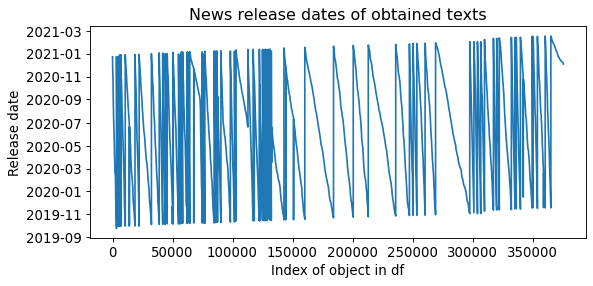

In [35]:
all_headlines_df['versionCreated'].plot()
plt.xlabel('Index of object in df')
plt.ylabel('Release date')
plt.title('News release dates of obtained texts')
# plt.grid(True, axis='x')
plt.savefig(path_project_folder + 'exhibits_saved/'+ 'News release dates of obtained texts', bbox_inches = "tight")

In [36]:
quasi_logger

,ric_i,ric_now,headlines_slice_i,headlines_number,up_to_date_ric,story_i,story_id_now,story_is_success,date_time
0,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,0.0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,True,NaN
1,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,1.0,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,True,NaN
2,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,2.0,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,True,NaN
3,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,3.0,urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,True,NaN
4,0,DTEGn.DE,0.0,100.0,2020-12-24T03:51:28,4.0,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,True,NaN
...,...,...,...,...,...,...,...,...,...
344964,32,PFE.N,66.0,100.0,2020-12-04 17:28:02+00:00,95.0,urn:newsml:reuters.com:20201204:nL4N2IK0LA:2,True,2021-02-24 00:12:55.153282
344965,32,PFE.N,66.0,100.0,2020-12-04 17:28:02+00:00,96.0,urn:newsml:reuters.com:20201204:nNRAdoazzw:1,True,2021-02-24 00:12:55.688442
344966,32,PFE.N,66.0,100.0,2020-12-04 17:28:02+00:00,97.0,urn:newsml:reuters.com:20201204:nL8N2IK1TG:1,True,2021-02-24 00:12:56.205766
344967,32,PFE.N,66.0,100.0,2020-12-04 17:28:02+00:00,98.0,urn:newsml:reuters.com:20201204:nL8N2IK1PU:1,True,2021-02-24 00:12:56.749798


In [37]:
# Сохранить версию all_headlines_df вручную
file_version = 1
folder_name = path_project_folder + folder_name_headlines
date_now = datetime.today().strftime("%Y-%m-%d")
file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
while file_name in os.listdir(folder_name):
    file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    file_version = file_version + 1
# C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
file_path = folder_name + file_name
all_headlines_df.to_csv(file_path, sep = ';', index=False)
print(file_path)

C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-02-24_v1.csv


In [38]:
# Сохранить версию логгера вручную
file_version = 1
folder_name = path_project_folder + folder_name_logger
date_now = datetime.today().strftime("%Y-%m-%d")
file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
while file_name in os.listdir(folder_name):
    file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    file_version = file_version + 1
file_path = folder_name + file_name
quasi_logger.to_csv(file_path, sep = ';', index=False)
print(file_path)

C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-02-24_v1.csv


In [33]:
print('df shape:', all_headlines_df.shape, ',  Num of rics:', all_headlines_df.groupby('ric')['ric'].nunique().sort_values(ascending=False).count())
print('StoryId duplicated:', all_headlines_df['storyId'].duplicated().sum())
print('Rows in df duplicated:', all_headlines_df.duplicated().sum())
print()
print('status error_when_trying_to_collect_story:', all_headlines_df[all_headlines_df['story'] == 'error_when_trying_to_collect_story']['story'].count())
print()
print('    Number of NA:')
print(len(all_headlines_df) - all_headlines_df.notna().sum())

df shape: (332300, 6) ,  Num of rics: 70
StoryId duplicated: 54034
Rows in df duplicated: 3630

status error_when_trying_to_collect_story: 1552

    Number of NA:
ric                 0
versionCreated      0
headline            0
storyId             0
sourceCode          0
story             153
dtype: int64


Median query time execution: 0.615866


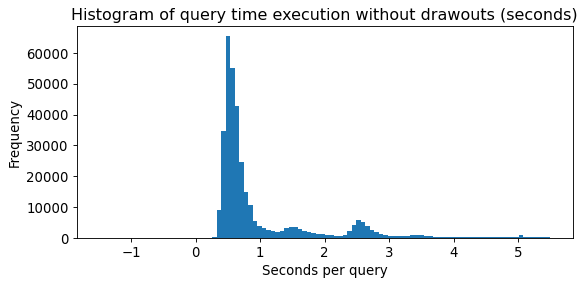

In [106]:
quasi_logger['date_time'] = pd.to_datetime(quasi_logger['date_time'])
quasi_logger['date_only'] = quasi_logger['date_time'].dt.date
quasi_logger['exec_seconds'] = quasi_logger['date_time'].diff() / np.timedelta64(1, 's')
exec_time_q99 = quasi_logger[quasi_logger['exec_seconds'] < quasi_logger['exec_seconds'].quantile(0.99)]
exec_time_q99['exec_seconds'].plot(kind='hist', bins = 100)
plt.title('Histogram of query time execution without drawouts (seconds)')
plt.xlabel('Seconds per query')
plt.ylabel('Frequency')
# plt.grid(True, axis='x')
plt.savefig(path_project_folder + 'exhibits_saved/'+ 'Histogram of query time execution without drawouts (seconds)', bbox_inches = "tight")
print('Median query time execution:', quasi_logger['exec_seconds'].median())

<AxesSubplot:ylabel='ric_now'>

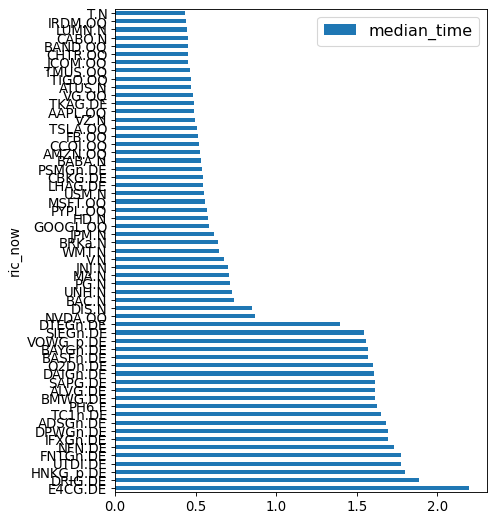

In [35]:
exec_time_q99.groupby(by='ric_now').agg(median_time=('exec_seconds', 'median')).sort_values(by='median_time', ascending=False).plot(kind='barh', figsize=(6,8))

<AxesSubplot:ylabel='date_only'>

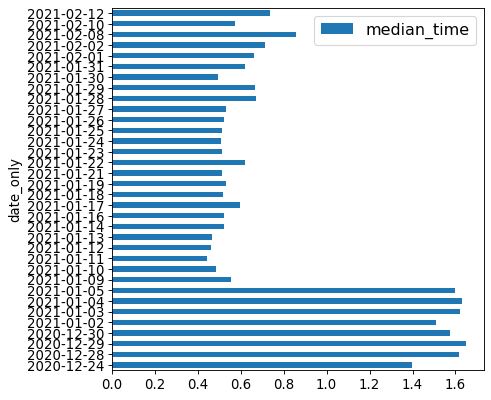

In [36]:
exec_time_q99.groupby(by='date_only').agg(median_time=('exec_seconds', 'median')).plot(kind='barh', figsize=(6,6))

<AxesSubplot:ylabel='ric_now'>

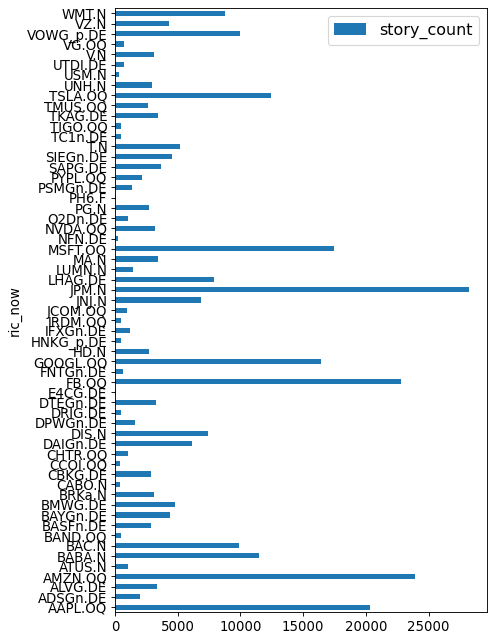

In [37]:
exec_time_q99.groupby(by='ric_now').agg(story_count=('story_id_now', 'count')).plot(kind='barh', figsize=(6,10))